In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from functions_SqRA import grid1, adjancency_matrix_sparse, build_Qo

font = {'size' : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

## System parameters

In [2]:
kB     = 0.008314463                 # kJ mol-1 K
T      = 300                         # K
mass   = 1                           # amu mol-1 (same mass for each atom)
gamma  = 1                           # ps-1 
D      = kB * T / mass / gamma       # nm2 ps-1
sigma  = np.sqrt(2 * D)              # nm ps-1/2
beta   = 1 / kB / T                  # kJ-1 mol 

## Forcefield

In [3]:
def Vbond(X, i, j, par_bonds):
    rij      = X[:,i] - X[:,j]
    norm_rij = np.sqrt( np.sum( rij ** 2 ) )
    
    return 0.5 * par_bonds[0] * ( norm_rij - par_bonds[1] ) ** 2

def Vangle(X, i, j, k, par_angles):
    ri_x = X[0,i]
    ri_y = X[1,i]
    ri_z = X[2,i]

    ri   =  np.array([ri_x, ri_y, ri_z])

    rj_x = X[0,j]
    rj_y = X[1,j]
    rj_z = X[2,j]
    
    rj   =  np.array([rj_x, rj_y, rj_z])

    rk_x = X[0,k]
    rk_y = X[1,k]
    rk_z = X[2,k]

    rk   =  np.array([rk_x, rk_y, rk_z])

    rij  = ri - rj
    rkj  = rk - rj

    norm_rij = np.sqrt( np.sum( rij ** 2 ) )
    norm_rkj = np.sqrt( np.sum( rkj ** 2 ) )
    
    theta_ijk = np.arccos( np.dot(rij,rkj) / ( norm_rij * norm_rkj ) )
    
    return 0.5 * par_angles[0] * ( theta_ijk - par_angles[1] ) ** 2

def Vdihedral(X, i, j, k, l, par_dihedrals):
    """Praxeolitic formula
    1 sqrt, 1 cross product"""
    p0 = X[:,i]
    p1 = X[:,j]
    p2 = X[:,k]
    p3 = X[:,l]

    b0 = -1.0*(p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2

    # normalize b1 so that it does not influence magnitude of vector
    # rejections that come next
    b1 /= np.linalg.norm(b1)

    # vector rejections
    # v = projection of b0 onto plane perpendicular to b1
    #   = b0 minus component that aligns with b1
    # w = projection of b2 onto plane perpendicular to b1
    #   = b2 minus component that aligns with b1
    v = b0 - np.dot(b0, b1)*b1
    w = b2 - np.dot(b2, b1)*b1

    # angle between v and w in a plane is the torsion angle
    # v and w may not be normalized but that's fine since tan is y/x
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    
    psi = np.degrees(np.arctan2(y, x))
    
    return par_dihedrals[0] * np.cos( par_dihedrals[1] * psi + par_dihedrals[2] ), psi

def Vcoulomb(X, i, j, q, par_coulomb):
    rij      = X[:,i] - X[:,j]
    norm_rij = np.sqrt( np.sum( rij ** 2 ) )
    
    return par_coulomb ** 2 * q[i] * q[j] / norm_rij

def Vlj(X, i, j, par_lj):
    rij      = X[:,i] - X[:,j]
    norm_rij = np.sqrt( np.sum( rij ** 2 ) )

    return par_lj[0] * ( par_lj[1] / norm_rij ) ** 12 - 2 * par_lj[0] * ( par_lj[1] / norm_rij ) ** 6

## Forcefield parameters

In [4]:
# Bond parameters
kb        = 1
r0        = 0.5
par_bonds = np.array([kb, r0])

# Angle parameters
ka         = 1
theta0     = np.pi / 3
par_angles = np.array([ka, theta0])

# Dihedral parameters
kd             = 1
periodicity    = 2
psi0           = np.pi / 3
par_dihedrals  = np.array([kd, periodicity, psi0])

# Coulomb parameters
kele        = 1
par_coulomb = kele
q           = np.array([+1, 0, 0, 0, -1])

# LJ parameters
eps        = 1
req        = 3
par_lj  = np.array([eps, req])

## Molecule parameters

In [5]:
# Number of atoms
Na = 5

# Number of dimensions per atom
Nd = 3

# Total number of dimensions
N  = Na * Nd

# Number of bonds, angles, dihedrals
Nbonds     = 4
Nangles    = 3
Ndihedrals = 2

# bonds, angles, dihedrals
bonds      = np.array([[0,1], [1,2], [2,3], [3,4]])
angles     = np.array([[0,1,2], [1,2,3], [2,3,4]])
dihedrals  = np.array([[0,1,2,3], [1,2,3,4]])

## System 1

Atom 1 moves in the space $(x,y,z)$.

Atom 2 moves on the plane $(x,y)$.

Atom 3 is fixed at the origin.

Atom 4 is fixed at some point $(\hat{x}_4, \hat{y}_4)$ on the plane $(x,y)$.

$$
\begin{pmatrix}
x_1, y_1, z_1 \\
x_2, y_2, 0 \\
0, 0, 0  \\
\hat{x}_4, \hat{y}_4, 0
\end{pmatrix}
$$
$12\rightarrow 5$ Degrees Of Freedoms (DOFs).


100000


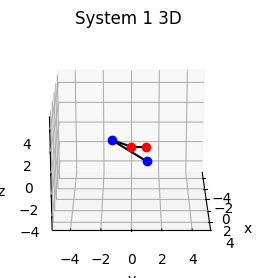

In [6]:
# Number of DOFs
Nd1 = 5

# Number of bins per each dimension + 1
Nx1 = 11


# One dimensional grid
a = 1.5
xcenters, xedges, xbins, dx = grid1(-a, a, Nx1)
bins1 = np.array([xbins, xbins, xbins, xbins, xbins])
flux1 = np.array([D/dx**2, D/dx**2, D/dx**2, D/dx**2, D/dx**2])

# Total number of bins / configurations
Nbins1 = np.prod(bins1)
print(Nbins1)

# 5-dimensional grid
grid = np.meshgrid(xcenters, xcenters, xcenters, xcenters, xcenters)

# grid contains all the possible configurations in a 5-dimensional hyper cube
# Add zeros coordinates 
X1  = np.array([[grid[0].flatten('C'), \
                 grid[1].flatten('C'), \
                 grid[2].flatten('C')],\
                [grid[3].flatten('C'), \
                 grid[4].flatten('C'), \
                 np.zeros(Nbins1)],  \
                [np.zeros(Nbins1),   \
                 np.zeros(Nbins1),   \
                 np.zeros(Nbins1)],
                [np.zeros(Nbins1),   \
                 np.ones(Nbins1),   \
                 np.zeros(Nbins1)]]).T

## Figure
fig = plt.figure(figsize=(21*in2cm, 6*in2cm))

ax = fig.add_subplot(1, 1, 1, projection='3d')

# Configuration
n = np.random.randint(0, Nbins1)

ax.plot3D([X1[n][0,0], X1[n][0,1]], [X1[n][1,0], X1[n][1,1]], [X1[n][2,0],X1[n][2,1]], 'k-')
ax.plot3D([X1[n][0,1], X1[n][0,2]], [X1[n][1,1], X1[n][1,2]], [X1[n][2,1],X1[n][2,2]], 'k-')
ax.plot3D([X1[n][0,2], X1[n][0,3]], [X1[n][1,2], X1[n][1,3]], [X1[n][2,2],X1[n][2,3]], 'k-')

ax.plot3D(X1[n][0,0],X1[n][1,0],X1[n][2,0], 'bo')
ax.plot3D(X1[n][0,1],X1[n][1,1],X1[n][2,1], 'bo')
ax.plot3D(X1[n][0,2],X1[n][1,2],X1[n][2,2], 'ro')
ax.plot3D(X1[n][0,3],X1[n][1,3],X1[n][2,3], 'ro')


ax.set_title('System 1 3D')
ax.set_aspect('auto', 'box')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.set_zlim([-5,5])
ax.view_init(20,-0)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0)
#fig.savefig('par5_1.png', format='png', dpi=900, bbox_inches='tight')

In [24]:
print(X1.shape)
print(xcenters)

(100000, 3, 4)
[-1.35 -1.05 -0.75 -0.45 -0.15  0.15  0.45  0.75  1.05  1.35]


## System 2

Atom 2 is fixed at some points $(\hat{x}_2, \hat{y}_2, 0)$.

Atom 3 is fixed.

Atom 4 can move along the axis $(0,y,0)$.

Atom 5 can in the space $(x,y,z)$.

$$
\begin{pmatrix}
\hat{x}_2, \hat{y}_2, 0 \\
0, 0, 0 \\
0, y_4, 0 \\
x_3, y_3, z_3 
\end{pmatrix}
$$
$12\rightarrow 4$ DOFs.


10000


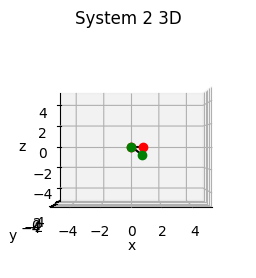

In [8]:
# Number of DOFs
Nd2 = 4

# Number of bins per each dimension + 1
Nx2 = 11

# One dimensional grid
#a = 1/5
xcenters, xedges, xbins, dx = grid1(-a, a, Nx2)
bins2 = np.array([xbins, xbins, xbins, xbins])
flux2 = np.array([D/dx**2, D/dx**2, D/dx**2, D/dx**2])

# Total number of bins / configurations
Nbins2 = np.prod(bins2)
print(Nbins2)

# 4-dimensional grid
grid = np.meshgrid(xcenters, xcenters, xcenters, xcenters)


# grid contains all the possible configurations in a 4-dimensional hyper cube
# Add zeros coordinates
X2  = np.array([[ 0.77*np.ones(xbins**4),   \
                 np.zeros(xbins**4),   \
                 np.zeros(xbins**4)],  \
                [np.zeros(xbins**4),   \
                 np.zeros(xbins**4),   \
                 np.zeros(xbins**4)],  \
                [np.zeros(xbins**4),   \
                 grid[0].flatten('C'), \
                 np.zeros(xbins**4)],  \
                [grid[1].flatten('C'), \
                 grid[2].flatten('C'), \
                 grid[3].flatten('C')]]).T


# Figure
fig = plt.figure(figsize=(21*in2cm, 6*in2cm))

ax = fig.add_subplot(1, 1, 1, projection='3d')


# Configuration
n = np.random.randint(0, Nbins2)


ax.plot3D([X2[n][0,0], X2[n][0,1]], [X2[n][1,0], X2[n][1,1]], [X2[n][2,0],X2[n][2,1]], 'k-')
ax.plot3D([X2[n][0,1], X2[n][0,2]], [X2[n][1,1], X2[n][1,2]], [X2[n][2,1],X2[n][2,2]], 'k-')
ax.plot3D([X2[n][0,2], X2[n][0,3]], [X2[n][1,2], X2[n][1,3]], [X2[n][2,2],X2[n][2,3]], 'k-')

ax.plot3D(X2[n][0,0],X2[n][1,0],X2[n][2,0], 'ro')
ax.plot3D(X2[n][0,1],X2[n][1,1],X2[n][2,1], 'ro')
ax.plot3D(X2[n][0,2],X2[n][1,2],X2[n][2,2], 'go')
ax.plot3D(X2[n][0,3],X2[n][1,3],X2[n][2,3], 'go')

ax.set_title('System 2 3D')
ax.set_aspect('auto', 'box')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.set_zlim([-5,5])
ax.view_init(0,-90)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0)
#fig.savefig('par5_1.png', format='png', dpi=900, bbox_inches='tight')

## Energy of the systems

In [9]:
V1 = np.zeros(Nbins1)


for c in range(Nbins1):

    for n in np.arange(0,2):
        V1[c] += Vbond(X1[c], bonds[n,0], bonds[n,1], par_bonds)

    for n in np.arange(0,2):
        V1[c] += Vangle(X1[c], angles[n,0], angles[n,1], angles[n,2], par_angles)

    V1[c] += Vdihedral(X1[c], dihedrals[0,0], dihedrals[0,1], dihedrals[0,2], dihedrals[0,3], par_dihedrals)[0]

In [10]:
V2 = np.zeros(Nbins2)
check = 321
for c in range(Nbins2):

    for n in np.arange(1,3):
        V2[c] += Vbond(X2[c], bonds[n,0], bonds[n,1], par_bonds)
        if c == check:
            print(V2[check])

    for n in np.arange(1,2):
        V2[c] += Vangle(X2[c], angles[n,0], angles[n,1], angles[n,2], par_angles)
        if c == check:
            print(V2[check])

    V2[c] += Vdihedral(X2[c], dihedrals[0,0], dihedrals[0,1], dihedrals[0,2], dihedrals[0,3], par_dihedrals)[0]

print(V2[check])

0.0012499999999999968
0.765562232290733
1.0086366816716283
1.9049126717452238


## Boltzmann weights

In [11]:
NanConfs1 = np.isnan(V1)
print(np.sum(NanConfs1))
NanConfs2 = np.isnan(V2)
print(np.sum(NanConfs2))

w1 = np.exp( - beta * V1 )
w1[NanConfs1] = 0.0

w2 = np.exp( - beta * V2 )
w2[NanConfs2] = 0.0

0
0


In [36]:
np.sqrt(w1)

array([0.57709024, 0.54445064, 0.83195251, ..., 0.64056317, 0.86078087,
       0.68052557])

## Adjacency matrices

In [13]:
A1    = adjancency_matrix_sparse(bins1, flux1, periodic=False)
A2    = adjancency_matrix_sparse(bins2, flux2, periodic=False)

In [39]:
A1[1,2]

27.714876666666658

## SqRA

In [14]:
Qo1 = build_Qo(w1, A1, Nbins1)[0]  # build_Qo: return Dinv *  A * Di, Dinv, Di
Qo2 = build_Qo(w2, A2, Nbins2)[0]  

#np.nan_to_num(Qo1.data, copy=False)
Qo1.data[np.isinf(Qo1.data)] = 0.0
Qo2.data[np.isinf(Qo2.data)] = 0.0

In [34]:
w1 * flux1[0]

array([ 9.2299726 ,  8.21542394, 19.1827125 , ..., 11.37200093,
       20.53516357, 12.83517636])

## E matrices

In [16]:
E1 = scipy.sparse.spdiags( Qo1.sum(axis=1).T, 0, Nbins1, Nbins1 )
E2 = scipy.sparse.spdiags( Qo2.sum(axis=1).T, 0, Nbins2, Nbins2 )

In [42]:
# i obtained the results without flux
print(E1.diagonal() / A1[0,1])
print(E2.diagonal() / A1[0,1])

[5.3169088  7.32794617 4.69054307 ... 8.40543992 5.05984321 5.32925169]


## Rate matrices

In [17]:
Q1     = Qo1 - E1 
Q2     = Qo2 - E2 

Nbins = Nbins1 * Nbins2
#evecs = np.zeros((Nbins, 14))

In [72]:
flux=flux1[0]
Q1.diagonal() / flux
# i have the same result here

array([-5.3169088 , -7.32794617, -4.69054307, ..., -8.40543992,
       -5.05984321, -5.32925169])

In [63]:
np.sum(Q1, axis=1)

matrix([[ 0.00000000e+00],
        [ 7.10542736e-15],
        [ 7.10542736e-15],
        ...,
        [-2.13162821e-14],
        [-3.55271368e-15],
        [ 7.10542736e-15]])

In [73]:
flux

27.714876666666658

In [97]:
(Q1[[0,1,10,100,1000,10000],0].todense())

matrix([[-147.35747173],
        [  29.37637251],
        [  22.78609984],
        [  26.57242464],
        [  22.74489165],
        [  30.94360732]])

In [67]:
c1s=Q1[:,0].todense()
c1s.sort()
c1s / flux

matrix([[-5.3169088],
        [ 1.0599496],
        [ 0.       ],
        ...,
        [ 0.       ],
        [ 0.       ],
        [ 0.       ]])

## Eigenvalues and eigenvectors

In [18]:
evals1, evecs1 = scipy.sparse.linalg.eigs(Q1, 4, which='LR')
evals2, evecs2 = scipy.sparse.linalg.eigs(Q2, 4, which='LR')

In [100]:
evals1

array([-2.11862252e-15+0.j, -2.41772478e+00+0.j, -2.69115975e+00+0.j,
       -2.85888388e+00+0.j])

In [99]:
evals2

array([ 2.81789297e-15+0.j, -2.62021491e+00+0.j, -2.87772364e+00+0.j,
       -2.86490627e+00+0.j])

In [19]:
# Kronecker product / sum rules to estimate eigenvalues/eigenvectors of the full system
evals = np.zeros(16)

k = 0
for i in range(4):
    for j in range(4):

        evals[k]     = evals1[j] + evals2[i]
        k = k + 1
        
        
# Unable to allocate 142. PiB for an array with shape (100000000, 100000000) and data type complex128 
"""evecs = np.zeros((Nbins, 4), dtype=np.float32)

k = 0
for i in range(2):
    for j in range(2):
        evecs[:,k]   = np.diag( \
                                     scipy.sparse.kron( scipy.sparse.spdiags( np.real(evecs1[:,i]), 0, Nbins1, Nbins1 ) , \
                                                        scipy.sparse.spdiags( np.real(evecs2[:,j]), 0, Nbins2, Nbins2 )   \
                                                      ).toarray()
                              )
        k = k + 1
"""

/tmp/ipykernel_2091625/1480343371.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  evals[k]     = evals1[j] + evals2[i]


'evecs = np.zeros((Nbins, 4), dtype=np.float32)\n\nk = 0\nfor i in range(2):\n    for j in range(2):\n        evecs[:,k]   = np.diag(                                      scipy.sparse.kron( scipy.sparse.spdiags( np.real(evecs1[:,i]), 0, Nbins1, Nbins1 ) ,                                                         scipy.sparse.spdiags( np.real(evecs2[:,j]), 0, Nbins2, Nbins2 )                                                         ).toarray()\n                              )\n        k = k + 1\n'

/home/htc/bzfsikor/code/tsqra/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


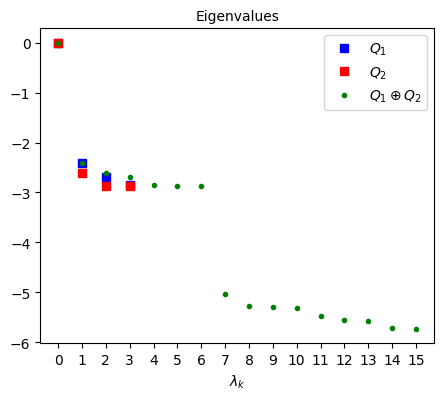

In [20]:
# Figure
fig = plt.figure(figsize=(10*in2cm, 8*in2cm))

ax = fig.add_subplot(1,1, 1)

ax.plot(evals1, 'bs',   label = r"$Q_1$")
ax.plot(evals2, 'rs',   label = r"$Q_2$")
ax.plot(-np.sort(-evals),  'g.', label = r"$Q_1 \oplus Q_2$")
ax.set_xticks(np.arange(0,16))
ax.set_xlabel(r"$\lambda_k$")
ax.set_title(r"Eigenvalues", fontsize = 10)
ax.legend()


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0)
#fig.savefig('figures/molecule_eigenvalues.pdf', format='pdf', dpi=900, bbox_inches='tight')

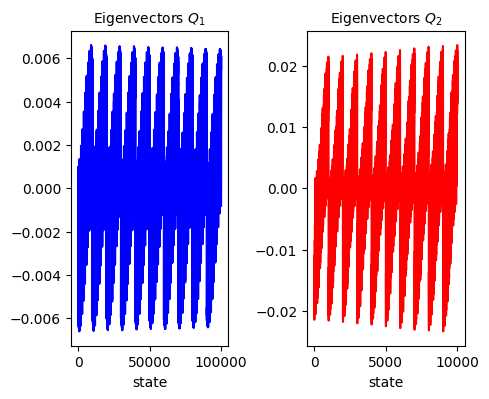

In [21]:
fig = plt.figure(figsize=(10*in2cm, 8*in2cm))

ax = fig.add_subplot(1, 2,1)
ax.plot(evecs1[:,1], 'b',   label = "System 1")
ax.set_xlabel(r"state")
ax.set_title(r"Eigenvectors $Q_1$", fontsize = 10)

ax = fig.add_subplot(1, 2, 2)
ax.plot(evecs2[:,1], 'r',   label = "System 2")
ax.set_xlabel(r"state")
ax.set_title(r"Eigenvectors $Q_2$", fontsize = 10)

#ax = fig.add_subplot(1, 3, 3)
#ax.plot(np.abs(evecs[:,0]),  'g', label = "Coupled")


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0)
#fig.savefig('figures/molecule_eigenvectors.pdf', format='pdf', dpi=900, bbox_inches='tight')

In [22]:
gg = np.zeros(Nbins1*Nbins2)


In [23]:
print(Nbins1)
print(Nbins2)

100000
10000
